# Estudando ridge e lasso

Utilizando a biblioteca [scikit learn](http://scikit-learn.org/stable/index.html) para a predição dos votos de deputados federais considerando dados das últimas eleições.
Tutorial utilizado como base [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models)


**A partir do livro Análise Multivariada de Dados (Hair, Black, Babin, Anderson e Tathan) 6ª edição, existem 6 etapas para a construção de modelos multivariados:**
- 1 Definição do problema: Desenvolver o modelo conceitual do problema. É preciso identificar as ideias, tópicos de interesse, o que se deseja analisar, o que espera do modelo obter e quais são as relações inerentes ao dominio (relação entre os atributos);

- 2 Definição do plano de análise: A partir do modelo conceitual realiza-se o planejamento que inclui atividades como:
    - Escolha da técnica multivariada a ser usada
    - Verificar requisitos pra implementar a técnica
    - Considerar o tamanho da amostra, tipos das variáveis e métodos de estimação (na maioria das vezes são inerentes a técnica) 
    - Plano para estimação de resultados agregados ou desagregados
    - Possívedidas de associação
    - Fórmulas para mapear efeitos não lineares ou interativos
    
    É como se fosse um questionário que aborde os tópicos acima;
    
    
- 3 Avaliação das suposições: Avaliação das suposições utilizando a técnica definida, basicamente responder a pergunta "O plano de análise pode ser satisfeito com a técnica escolhida?". Por exemplo: Para utilizar a técnica baseadas em inferencia estatisticas precisam ter suposições como normalidade multivariada, linearidade e  independencia de termos de erro, devem ser safisteitas;

- 4 Estimação do modelo: Estimar e/ou melhorar parâmetros do modelo a fim de atingir um ajuste melhor do modelo;

- 5 Interpretação da variáveis: Uma vez que se tenha um modelo aceitável é o momento de interpretar os resltaddos para entender a natureza da relação multivariada;

- 6 Validação: Submissão do modelo a um conjunto final de análises para medir o grau de generabilidade do modelo pelo método de validação definido no plano.

In [8]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-whitegrid')

Função para normalizar dados
    -

In [18]:
def normalizando_dados(dataframe):
    
    numeric_features = dataframe.dtypes[dataframe.dtypes != "object"].index

    skewed_features = dataframe[numeric_features].apply(lambda x: x.dropna().skew())

    skewed_features = skewed_features[skewed_features > 0.75]

    skewed_features = skewed_features.index

    dataframe[skewed_features] = np.log1p(dataframe[skewed_features])

    dataframe = pd.get_dummies(dataframe)

    dataframe = dataframe.fillna(dataframe.mean())
    
    return dataframe

#### Importando dados

In [10]:
eleicoes = pd.read_csv('/home/lsp/dados/am/eleicoes_2006_a_2010.csv')

eleicoes = normalizando_dados(eleicoes)

#### Retirando atributos agregados ou que não possuem valor para a análise

In [11]:
eleicoes = eleicoes.drop(['sequencial_candidato', 'media_receita', 'media_despesa'], axis=1)
eleicoes.head()

,ano,quantidade_doacoes,quantidade_doadores,total_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,...,"ocupacao_TÉCNICO DE OBRAS CIVIS, ESTRADAS, SANEAMENTO E ASSEMELHADOS",ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA
0,2006,1.945910,1.945910,9.717218,8.324939,9.105091,8.748464,7.170888,2.708050,2.708050,...,0,0,0,0,0,0,1,0,0,0
1,2006,2.639057,2.639057,10.035699,8.798757,9.615872,6.908755,5.308268,3.218876,3.178054,...,0,0,0,0,0,0,0,0,0,0
2,2006,2.890372,2.833213,11.905790,7.719130,10.438547,11.038461,10.993748,4.820282,4.691348,...,0,0,0,0,0,0,0,0,0,0
3,2006,1.945910,1.945910,8.007074,8.324939,7.048386,7.004991,6.621406,2.197225,2.197225,...,0,0,0,0,0,0,0,0,0,0
4,2006,3.891820,3.891820,9.634619,8.324939,10.837206,10.011960,11.141035,4.897840,4.795791,...,0,0,0,0,0,0,0,0,0,0


### Funções para visualização

In [96]:
def vis_residuos_vs_predicoes(y_pred, y_real, titulo):
    matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
    predicoes = pd.DataFrame({"predicoes":y_pred, "valor_real":y_real})
    predicoes["residuos"] = predicoes["valor_real"] - predicoes["predicoes"]
    predicoes.plot(x = "predicoes", y = "residuos",kind = "scatter")
    plt.title(titulo)


# Modelos de Regressão

## 1 - Regressão sem regularização

Importando módulos necessários

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error

Treinando o modelo com os dados de treino

In [23]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Predizendo os valores de y para dos conjunto de teste

In [85]:
y_pred_model_reg = reg.predict(x_test)
y_pred_model_reg

array([  7.99944109,   8.11780229,   8.71432984, ...,  13.28528069,
         8.83738128,   5.43864748])

#### Calculando métricas para avaliação do modelo

**Coeficientes calculados para os atributos**

In [25]:
reg.coef_

array([-0.12995877, -0.43079614,  0.94127631, ...,  0.        ,
       -0.30674874, -0.15482578])

**MSE** - Média do quadrado do erro

In [86]:
mse = mean_squared_error(y_test, y_pred_model_reg)
mse

2.1555409459129322

### RMSE - Regressão sem regularização

In [27]:
np.sqrt(mse)

1.4681760609385144

**R²**

In [148]:
r2_score(y_test, y_pred_model_reg)

0.44631584708034466

In [88]:
explained_variance_score(y_test, y_pred_model_reg)

0.44633686753263557

## 1.1 - Resíduos x Predições: Regressão sem regularização

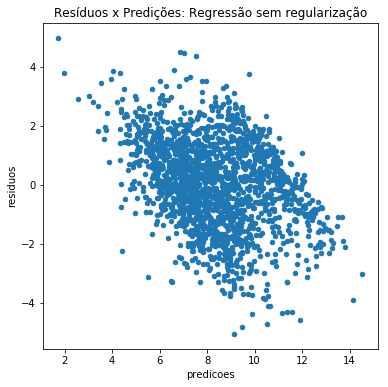

In [97]:
vis_residuos_vs_predicoes(y_pred_model_reg, y_test, "Resíduos x Predições: Regressão sem regularização")

É possível identificar que grande parte dos resíduos estão dispostos em torno do 0 o que indica uma boa adequabilidade, mas ao olhar também o histograma é possível ver que os valores reais estão mais concentrados à direita, enquanto os valores das predições estão mais alinhados ao meio.

## Imports e definição de funções auxiliares

In [41]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

Função para calcular as métricas RMSE e R² do modelo com validação cruzada.

In [53]:
def calc_rmse(model, cv):
    rmse = np.sqrt(-cross_val_score(model, x_all, y_all, scoring="neg_mean_squared_error", cv=cv))
    print("RMSE is: {0} ".format(rmse))
    return rmse

In [54]:
def calc_r2(model, cv):
    r2 = np.sqrt(cross_val_score(model, x_all, y_all, scoring="r2", cv=cv))
    print("R² is: {0} ".format(r2))
    return r2

In [55]:
def calc_variance(model, cv):
    explained_variance = np.sqrt(cross_val_score(model, x_train, y_train, scoring="explained_variance", cv=cv))
    print("Variance is: {0} ".format(explained_variance))
    return explained_variance

Função para gerar visualização dos alphas x medidas de validação

In [76]:
def gerar_vis_validacao(measures, alphas, title_measure):
    matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
    data = pd.Series(measures, index=alphas)
    data.plot(title = "Validação")
    plt.xlabel("alpha")
    plt.ylabel(title_measure)

## 2 - Ridge
Atribuindo alguns valores para alfa e verificando como o RMSE se comporta

In [73]:
alphas = [0.2, 0.5, 2, 5, 7]
cv = 5

In [74]:
ridge_rmse = [calc_rmse(Ridge(alpha=alpha), cv).mean() 
            for alpha in alphas]

ridge_rmse

RMSE is: [ 0.94542671  0.91477244  0.98003962  0.96358065  0.90587968] 
RMSE is: [ 0.93779595  0.91187397  0.97762377  0.9628892   0.90424296] 
RMSE is: [ 0.93351704  0.91395143  0.97573539  0.96417145  0.90562284] 
RMSE is: [ 0.93491867  0.9170001   0.97513792  0.96592461  0.90776448] 
RMSE is: [ 0.93592515  0.9179763   0.9749089   0.96670571  0.90857776] 


[0.94193982108037777,
 0.93888517293436602,
 0.93859963029226168,
 0.94014915399176568,
 0.94081876469072001]

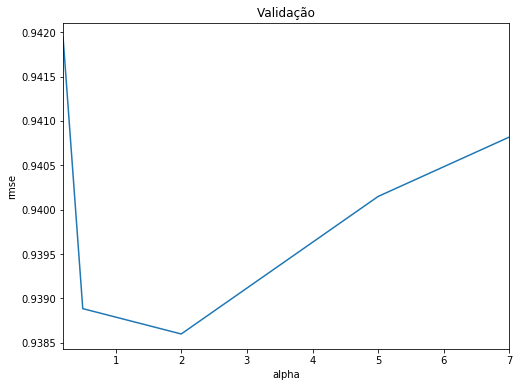

In [77]:
gerar_vis_validacao(ridge_rmse, alphas, "rmse")

In [78]:
ridge_r2 = [calc_r2(Ridge(alpha=alpha), cv).mean() 
            for alpha in alphas]

ridge_r2

R² is: [ 0.8795632   0.88227017  0.87046532  0.87738733  0.88305574] 
R² is: [ 0.88162964  0.88306438  0.87115034  0.87757551  0.88350579] 
R² is: [ 0.88277896  0.88249546  0.87168425  0.8772264   0.88312643] 
R² is: [ 0.88240323  0.88165756  0.87185289  0.87674812  0.88253619] 
R² is: [ 0.88213297  0.8813885   0.87191749  0.87653465  0.88231158] 


[0.87854835270785137,
 0.87938513207348623,
 0.87946230253377278,
 0.87903959749268223,
 0.87885704112741792]

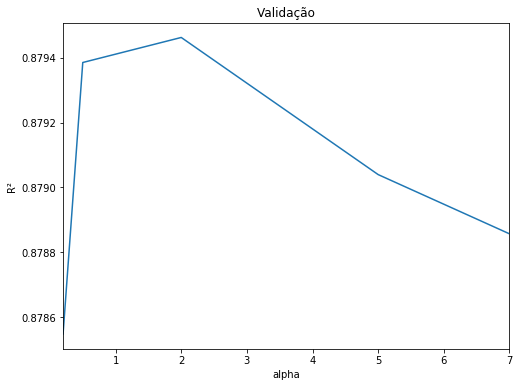

In [79]:
gerar_vis_validacao(ridge_r2, alphas, "R²")

In [80]:
ridge_variance = [calc_variance(Ridge(alpha=alpha), cv).mean() 
            for alpha in alphas]

ridge_variance

Variance is: [ 0.88302886  0.87104974  0.87045504  0.8802637   0.8635406 ] 
Variance is: [ 0.88380839  0.87172266  0.8713568   0.88152624  0.8646269 ] 
Variance is: [ 0.88485918  0.87229348  0.87145786  0.88271309  0.86527695] 
Variance is: [ 0.88492978  0.87207219  0.8714333   0.88307116  0.86542525] 
Variance is: [ 0.88469428  0.8718233   0.87134953  0.88305326  0.8654376 ] 


[0.87366759003042294,
 0.87460819662454858,
 0.87532011206342619,
 0.87538633416326062,
 0.87527159444230185]

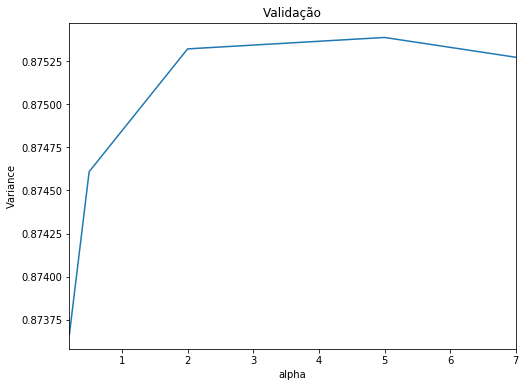

In [81]:
gerar_vis_validacao(ridge_variance, alphas, "Variance")

### Criando um modelo Ridge com o alfa que obteve o menor RMSE

In [82]:
model_ridge = Ridge(alpha=2)

model_ridge.fit(x_train, y_train)

Ridge(alpha=2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [166]:
y_pred_model_ridge = model_ridge.predict(x_test)
y_pred_model_ridge

array([  7.08237092,   7.24481173,   8.95923006, ...,  11.59556633,
         6.83377208,   6.17855605])

### RMSE - Ridge

In [169]:
mse_ridge = mean_squared_error(y_test, y_pred_model_ridge)
mse_ridge

0.91263556592493766

In [168]:
np.sqrt(mse)

0.95531961454004366

### R²

In [190]:
r2_score(y_test, y_pred_model_ridge)

0.76557538783867285

## 2.1 - Resíduos x Predições: Ridge

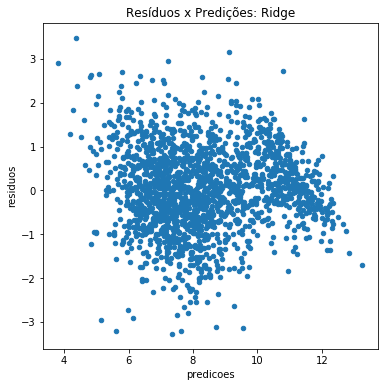

In [100]:
vis_residuos_vs_predicoes(y_pred_model_ridge, y_test, "Resíduos x Predições: Ridge")

## 3 - Lasso

In [182]:
model_lasso = LassoCV(alphas=[1, 0.1, 0.001, 0.005], max_iter=3000).fit(x_train, y_train)

model_lasso

LassoCV(alphas=[1, 0.1, 0.001, 0.005], copy_X=True, cv=None, eps=0.001,
    fit_intercept=True, max_iter=3000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

Verificando qual foi o alfa escolhido através da `cross validation`

In [183]:
model_lasso.alpha_

0.001

In [186]:
def calc_rmse_lasso(model, cv):
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv=cv))
    print("RMSE is: {0} ".format(rmse))
    return rmse

### RMSE Lasso

In [187]:
rmse_lasso = calc_rmse_lasso(model_lasso, 3).mean()
rmse_lasso

RMSE is: [ 0.97446336  0.94370415  0.98538898] 


0.96785216488202686

In [188]:
y_pred_model_lasso = model_lasso.predict(x_test)
y_pred_model_lasso

array([  7.06053936,   7.3044596 ,   9.02419173, ...,  11.54955376,
         6.47240074,   6.33241885])

### R²

In [189]:
model_lasso.score(x_test, y_test)

0.76640759329868591

In [192]:
coef = pd.Series(model_lasso.coef_, index = x_train.columns)
print("Lasso selecionou " + str(sum(coef != 0)) + " variáveis e rejeitou " + 
      str(sum(coef == 0)) + " variáveis")

Lasso selecionou 197 variáveis e rejeitou 6837 variáveis


In [199]:
descricao_coeficientes = pd.concat([coef.sort_values().head(10),
                                   coef.sort_values().tail(15)])

descricao_coeficientes

nome_PAULO HERBAN MACIEL JACOB FILHO        -2.569734
nome_MAURO DE OLIVEIRA CARVALHO             -2.343771
nome_DEMOSTENES BATISTA VERAS FILHO         -1.512312
nome_RENILDO BOTELHO PIMENTEL               -1.501057
nome_ANTONIO EDERVAL DE LIMA                -1.488709
nome_GERSON BENEDICTO                       -1.258312
nome_RICARDO SALVINO DO NASCIMENTO          -1.250789
nome_ANTÔNIO XAVIER DE OLIVEIRA             -1.115120
uf_RR                                       -0.992530
ocupacao_ESCRITOR E CRÍTICO                 -0.991517
nome_GOIACIARA TAVARES CRUZ                  0.598030
ocupacao_MÚSICO                              0.598857
nome_FRANCISCO RODRIGUES DE ALENCAR FILHO    0.606942
nome_JOSE AUGUSTO ALBANO                     0.617317
nome_CARLOS ALBERTO DA SILVA BRAZ            0.619684
uf_CE                                        0.814088
nome_EDMUNDO MIGUEL MARTINS                  0.872200
nome_RAIMUNDO NONATO TANURI BENTO            0.918988
nome_ELIANE VIANA JORDÃO FER

Text(0.5,1,'Resumo de coeficientes considerados')

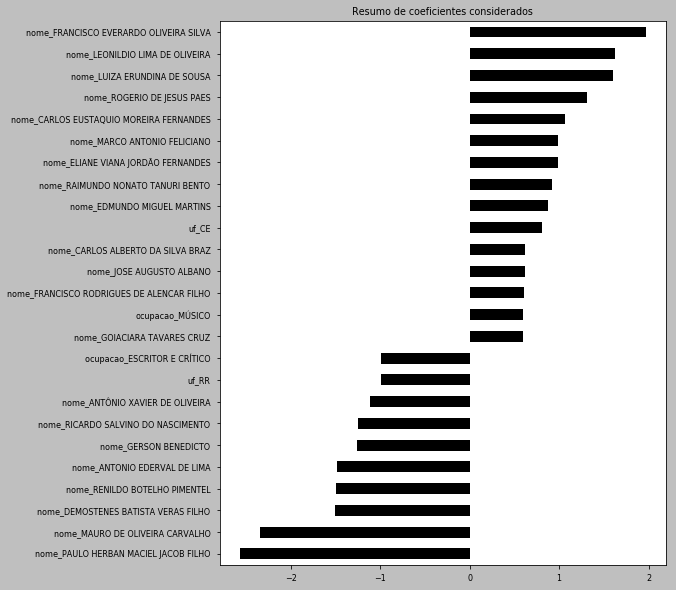

In [200]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
descricao_coeficientes.plot(kind= 'barh')
plt.title("Resumo de coeficientes considerados")

## 3.1 - Resíduos x Predições: Lasso

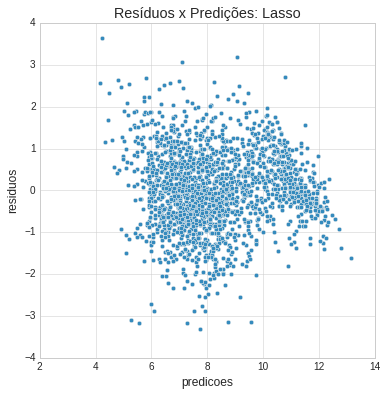

In [253]:
vis_residuos_vs_predicoes(y_pred_model_lasso, y_test, "Resíduos x Predições: Lasso")

A distribuição dos resíduos demonstra também uma boa adequabilidade, e possui aparencia muito semelhante ao do modelo Ridge. 

## 4 - Regressão com o KNN

In [243]:
from sklearn.neighbors import KNeighborsRegressor

In [244]:
model_knn = KNeighborsRegressor(n_neighbors=3).fit(x_train, y_train)

In [245]:
y_pred_model_knn = model_knn.predict(x_test)

In [246]:
y_pred_model_knn

array([  6.54863822,   6.07673994,   8.92986195, ...,  11.36204768,
         5.84772478,   5.88171113])

### R² KNN

In [249]:
r2_score(y_test, y_pred_model_knn)

0.69581381035675116

### RMSE KNN

In [250]:
mse_knn = mean_squared_error(y_test, y_pred_model_knn)
np.sqrt(mse_knn)

1.0882203373834987

## 4.1 - Resíduos x Predições: KNN

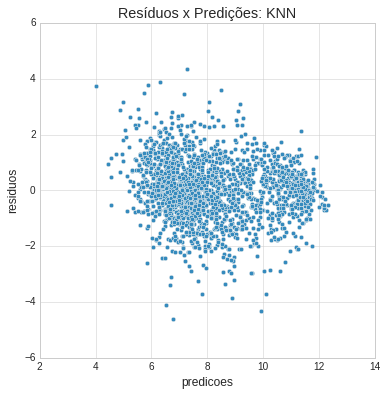

In [255]:
vis_residuos_vs_predicoes(y_pred_model_knn, y_test, "Resíduos x Predições: KNN")

## Resíduos X Predições dos Modelos

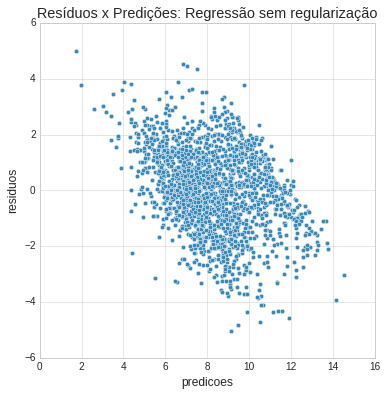

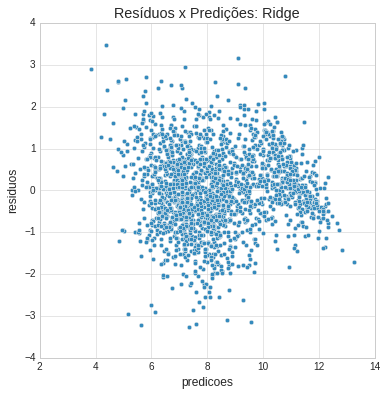

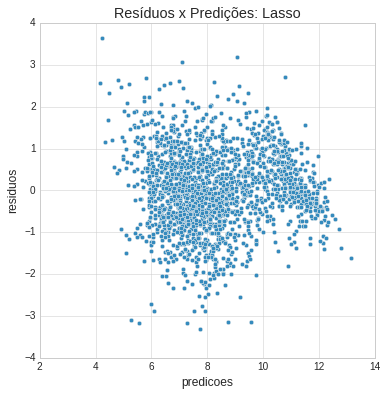

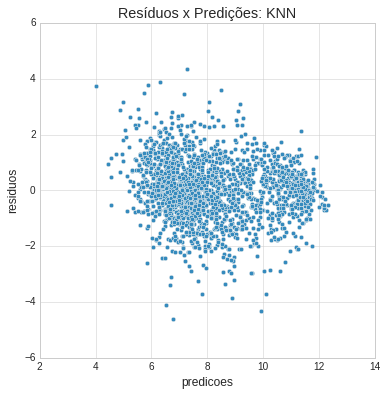

In [256]:
vis_residuos_vs_predicoes(y_pred_model_reg, y_test, "Resíduos x Predições: Regressão sem regularização")
vis_residuos_vs_predicoes(y_pred_model_ridge, y_test, "Resíduos x Predições: Ridge")
vis_residuos_vs_predicoes(y_pred_model_lasso, y_test, "Resíduos x Predições: Lasso")
vis_residuos_vs_predicoes(y_pred_model_knn, y_test, "Resíduos x Predições: KNN")

## Importando dados das eleições de 2014

In [25]:
eleicoes_2014 = pd.read_csv('/home/lsp/dados/am/eleicoes_2014.csv')

In [26]:
eleicoes_2014 = normalizando_dados(eleicoes_2014)

In [27]:
eleicoes_2014 = eleicoes_2014.drop(['sq_candidato', 'media_receita', 'media_despesa'], axis=1)
eleicoes_2014.head()

,ano,qtd_doacoes,qtd_doadores,total_receita,recursos de outros candidatos/comitês,recursos de pessoas físicas,recursos de pessoas jurídicas,recursos próprios,qtd_despesas,qtd_fornecedores,...,descricao_ocupacao_TÉCNICO DE QUÍMICA,descricao_ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,descricao_ocupacao_TÉCNICO EM EDIFICAÇÕES,descricao_ocupacao_TÉCNICO EM INFORMÁTICA,descricao_ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"descricao_ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",descricao_ocupacao_VEREADOR,descricao_ocupacao_VETERINÁRIO,descricao_ocupacao_VIGILANTE,descricao_ocupacao_ZOOTECNISTA
0,2014,1.386294,1.386294,7.365813,8.442226,7.313887,10.039024,8.505303,1.386294,1.386294,...,0,0,0,0,0,0,0,0,0,0
1,2014,1.791759,1.791759,8.064951,8.442226,8.039480,10.039024,8.505303,1.945910,1.791759,...,0,0,0,0,0,0,0,0,1,0
2,2014,3.713572,3.663562,12.716781,7.562198,11.092869,11.945818,11.652696,4.983607,4.941642,...,0,0,0,0,0,0,0,0,0,0
3,2014,3.401197,3.401197,11.962218,10.574474,11.138739,9.741027,8.826758,4.919981,4.804021,...,0,0,0,0,0,0,0,0,0,0
4,2014,5.081404,4.990433,13.474546,9.210440,12.757293,12.531776,11.264477,6.251904,5.872118,...,0,0,0,0,0,0,0,0,0,0
